In [2]:
import os
# print(os.listdir("C://Users//navin//Dropbox//Ryerson University//CIND 820//complaints"))

import pandas as pd
import numpy as np
import zipfile
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics
#import warnings

In [3]:
df = pd.read_csv('complaints.csv')
#The dataset can be found on 
#https://catalog.data.gov/dataset/consumer-complaint-database
#our dataset is download on Sept 17, 2020
df.shape

(1757764, 18)

In [4]:
#dfNew=pd.read_csv('complaints_samples.csv')

In [5]:
dfNew = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
dfNew = dfNew[pd.notnull(dfNew['Consumer complaint narrative'])]
dfNew = dfNew[pd.notnull(dfNew['Product'])]
# Renaming second column for a simpler name
dfNew.columns = ['Product', 'Consumer_complaint'] 

dfNew.shape

(596333, 2)

In [6]:
dfNew.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other reports', 
              'Credit reporting': 'Credit reporting, repair, or other reports',
              'Credit card': 'Credit card or prepaid card',
              'Prepaid card': 'Credit card or prepaid card',
              'Payday loan': 'Payday loan, title loan, or personal loan',
              'Money transfers': 'Money transfer, virtual currency, or money service',
              'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [7]:
dfNew.head(5)

,Product,Consumer_complaint
0,"Credit reporting, repair, or other reports",Although I am checking for and addressing miss...
1,Debt collection,transworld systems inc. \nis trying to collect...
3,Debt collection,"Over the past 2 weeks, I have been receiving e..."
5,Debt collection,Quickclickloans.com hired an attorney XXXX XXX...
6,"Credit reporting, repair, or other reports","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/..."


In [8]:
dfNewOriginal=dfNew.copy()
#dfNew=dfNew[:1000]


In [9]:
#Random Sampling
dfNew=dfNew.sample(n=10000, random_state=6)
dfNew.head(5)
#dfNew.to_csv ('complaints_samples.csv', index = False, header=True)

,Product,Consumer_complaint
1333694,"Credit reporting, repair, or other reports",I have disputed several times with Equifax and...
1382991,Debt collection,On XXXX XXXX I received a letter from first na...
374241,"Payday loan, title loan, or personal loan",Company : USA Cash Services I got an installme...
1488000,Credit card or prepaid card,"On Tuesday, XX/XX/2016 I logged into my accoun..."
19669,"Payday loan, title loan, or personal loan",WENT ON XXXX TODAY AND GOT AD FOR CONSUMER LOA...


PreProcessing

Lowercase

Remove Punctuation

Remove Stop words

Romove Digits

Limmatization


In [10]:
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x: ' '.join([i.lower() for i in x.split()]))

In [11]:
import string
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x:' '.join([char for char in x.split() if char not in string.punctuation]))
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].str.replace(r'[^\w\s]'," ")
dfNew['Consumer_complaint'] = dfNew['Consumer_complaint'].str.replace(r"xx+\s"," ")
dfNew['Consumer_complaint'] = dfNew['Consumer_complaint'].str.replace(r"xx+[a-z]+\s"," ")
dfNew['Consumer_complaint'] = dfNew['Consumer_complaint'].str.replace(r"[a-z]+xx+\s"," ")
dfNew['Consumer_complaint'] = dfNew['Consumer_complaint'].str.replace(r"xxxx"," ")

In [12]:
#pip install nltk
from nltk.corpus import stopwords
stopE = stopwords.words('english')
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x: ' '.join([char for char in x.split() if char not in stopE]))

In [16]:
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x: ' '.join([char for char in x.split() if not char.isdigit()]))

dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x: ' '.join([char for char in x.split() if char.isalpha()]))

In [17]:
# pip install pattern
# Run this part twice
import pattern

from pattern.en import lemma
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x:' '.join([lemma(wd) for wd in x.split()]))

In [18]:
dfNew.Consumer_complaint.head(10)

1333694    dispute several time equifax actual investigat...
1382991    receive letter first national collection burea...
374241     company usa cash service get installment loan ...
1488000    tuesday log account review go activity stateme...
19669      go today get ad consumer loan one main ad inst...
1321083    make payment subsidize loan unsubsidize loan p...
702610     transunion verify collection however provide p...
1300540    medical debt owe original amount comprehensive...
1354293    still show credit report state balance send le...
1663457    store credit card spend variou purchase past y...
Name: Consumer_complaint, dtype: object



Using TF-IDF-vectors, that have been calculated with the entire corpus (training and test subsets combined), while training the model might introduce some data leakage and hence yield in too optimistic performance measures. This is because the IDF-part of the training set's TF-IDF features will then include information from the test set already.

Calculating them completely separately for the training and test set is not a good idea either, because besides testing the quality of your model then you will be also testing the quality of your IDF-estimation. And because the test set is usually small this will be a poor estimation and will worsen your performance measures.

Therefore I would suggest (analogously to the common mean imputation of missing values) to perform TF-IDF-normalization on the training set seperately and then use the IDF-vector from the training set to calculate the TF-IDF vectors of the test set.


In [16]:
from sklearn.model_selection import train_test_split
y = dfNew['Product']
X=dfNew.Consumer_complaint
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tfidf = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X_train_counts = tfidf.fit_transform(X_train)
X_test_counts = tfidf.transform(X_test)

TF-IDF Matrix for whole document

In [17]:

vectors = tfidf.fit_transform(dfNew.Consumer_complaint)
feature_names = tfidf.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df1 = pd.DataFrame(denselist, columns=feature_names)
df1.head(20)

,abide,ability,able,absolutely,absurd,abuse,abusive,ac,acc,accept,...,www,ye,year,yell,yesterday,yet,york,young,yr,zero
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.125627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
6,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
7,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
8,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
9,0.0,0.0,0.069831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.107046,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


SVM

LinearSVC(penalty='l2', loss='squared_hinge', *, dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)

C float, default=1.0

   Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.
multi_class{‘ovr’, ‘crammer_singer’}, default=’ovr’

   Determines the multi-class strategy if y contains more than two classes. "ovr" trains n_classes one-vs-rest classifiers, while "crammer_singer" optimizes a joint objective over all classes. While crammer_singer is interesting from a theoretical perspective as it is consistent, it is seldom used in practice as it rarely leads to better accuracy and is more expensive to compute. If "crammer_singer" is chosen, the options loss, penalty and dual will be ignored.


max_iter int, default=1000

   The maximum number of iterations to be run.

   




In [18]:
classifier = LinearSVC(max_iter=100, C=1, multi_class='ovr')


classifier.fit(X_train_counts, y_train) 
y_pred = classifier.predict(X_test_counts)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 10  20   0   5   5   3   2   2   0   0   0   0]
 [ 11  36   1  13   4   2   2   3   0   0   0   0]
 [  0   0   2   3   3   9   0   5   0   4   0  11]
 [  5  12   1 148  23   9   6   1   0   1   0   0]
 [  0   0   1  20 698  65   0  13   0   1   7   6]
 [  1   3   1   5  64 320   1   9   0   2   8   3]
 [  0   8   0   2   1   4  31   0   0   0   0   1]
 [  0   2   0   3  11   9   0 182   0   1   0   0]
 [  0   0   0   0   0   1   0   1   0   0   0   0]
 [  2   0   1   0   5   7   0   4   0   9   3   0]
 [  0   0   0   2  10   9   0   1   0   1  63   0]
 [  0   0   5   3   7   5   0   1   0   3   1  11]]
                                                    precision    recall  f1-score   support

                           Bank account or service       0.34      0.21      0.26        47
                       Checking or savings account       0.44      0.50      0.47        72
                                     Consumer Loan       0.17      0.05      0.08        37
                  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
classifier = LinearSVC(max_iter=1000, C=1, multi_class='ovr')
classifier.fit(X_train_counts, y_train) 
y_pred = classifier.predict(X_test_counts)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 10  20   0   5   5   3   2   2   0   0   0   0]
 [ 11  36   1  13   4   2   2   3   0   0   0   0]
 [  0   0   2   3   3   9   0   5   0   4   0  11]
 [  5  12   1 148  23   9   6   1   0   1   0   0]
 [  0   0   1  20 698  65   0  13   0   1   7   6]
 [  1   3   1   5  64 320   1   9   0   2   8   3]
 [  0   8   0   2   1   4  31   0   0   0   0   1]
 [  0   2   0   3  11   9   0 182   0   1   0   0]
 [  0   0   0   0   0   1   0   1   0   0   0   0]
 [  2   0   1   0   5   7   0   4   0   9   3   0]
 [  0   0   0   2  10   9   0   1   0   1  63   0]
 [  0   0   5   3   7   5   0   1   0   3   1  11]]
                                                    precision    recall  f1-score   support

                           Bank account or service       0.34      0.21      0.26        47
                       Checking or savings account       0.44      0.50      0.47        72
                                     Consumer Loan       0.17      0.05      0.08        37
                  


Random Hyperparameter Grid
Instead of searching manually to find the best classifier parameter, I use RandomizedSearchCV. 

To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting. On each iteration, the algorithm will choose a difference combination of the features. However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

In [19]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV 

max_iter = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 20)]
C= [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)]

multi_class= ['ovr', 'crammer_singer']


random_grid = {'max_iter': max_iter,
               'C': C,
               'multi_class': multi_class,
               }
pprint(random_grid)

{'C': [1, 12, 23, 34, 45, 56, 67, 78, 89, 100],
 'max_iter': [50,
              100,
              150,
              200,
              250,
              300,
              350,
              400,
              450,
              500,
              550,
              600,
              650,
              700,
              750,
              800,
              850,
              900,
              950,
              1000],
 'multi_class': ['ovr', 'crammer_singer']}


The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 100 and 3 respectively). More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time.

In [28]:
# Use the random grid to search for best hyperparameters
from sklearn import preprocessing
y = dfNew['Product']
X=dfNew.Consumer_complaint
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
enc = preprocessing.LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)
tfidf_vect = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
tfidf_vect=tfidf_vect.fit(dfNew.Consumer_complaint)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)
# First create the base model to tune
SVM = LinearSVC()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
SVM_random = RandomizedSearchCV(estimator = SVM, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
SVM_random.fit(xtrain_tfidf, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                       fit_intercept=True, intercept_scaling=1,
                                       loss='squared_hinge', max_iter=1000,
                                       multi_class='ovr', penalty='l2',
                                       random_state=None, tol=0.0001,
                                       verbose=0),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'C': [1, 12, 23, 34, 45, 56, 67, 78, 89,
                                              100],
                                        'max_iter': [50, 100, 150, 200, 250,
                                                     300, 350, 400, 450, 500,
                                                     550, 600, 650, 700, 750,
                                                     800, 850, 900, 950, 1000],
                           

In [29]:
print('Best Parameter',SVM_random.best_params_)
print('Best score', SVM_random.best_score_)
best_SVM=SVM_random.best_params_

Best Parameter {'multi_class': 'crammer_singer', 'max_iter': 850, 'C': 1}
Best score 0.757874414235355


In [30]:
best_SVM

{'multi_class': 'crammer_singer', 'max_iter': 850, 'C': 1}

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define.

In [31]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    
    'max_iter': [850, 830, 880],
    'multi_class': ['crammer_singer'],
    'C': [1, 5], 
}
# Create a based model
SVM = LinearSVC()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = SVM, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(xtrain_tfidf, y_train)

best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, test_features, test_labels)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   13.0s finished
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [32]:
print('Best Classifier parameter', grid_search.best_params_)
print('Best Score',grid_search.best_score_)
print('Best Estimator', grid_search.best_estimator_)
best_SVM_grid=grid_search.best_params_


Best Classifier parameter {'C': 1, 'max_iter': 850, 'multi_class': 'crammer_singer'}
Best Score 0.7577493829775405
Best Estimator LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=850,
          multi_class='crammer_singer', penalty='l2', random_state=None,
          tol=0.0001, verbose=0)


CROSS VALIDATION STRATIFIED KFOLD

In [37]:
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
labels_l=['Bank account or service', 'Checking or savings account','Consumer Loan','Credit card or prepaid card',
          'Credit reporting, repair, or other reports','Debt collection',
          'Money transfer, virtual currency, or money service' ,'Mortgage','Other financial service',
          'Payday loan, title loan, or personal loan','Student loan','Vehicle loan or lease'] 
metricsSVM_s = []
conf_matrix_list_of_arrays_SVM_s =[]

SVM_report = pd.DataFrame(columns=['precision' , 'recall' ,'f1-score' , 'support'])

skf = StratifiedKFold(n_splits=10)
for train_index, test_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    #vect = CountVectorizer(ngram_range=(1,2), max_features=1000 , stop_words="English")
    vect=CountVectorizer(max_features=1000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)    
    
    
    SVM_Final_s=LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=850,
          multi_class='crammer_singer', penalty='l2', random_state=None,
          tol=0.0001, verbose=0)
    
    
    SVM_Final_s.fit(X_train_dtm, y_train)
    y_pred_class_SVM =SVM_Final_s.predict(X_test_dtm)
    metricsSVM_s.append(accuracy_score(y_test, y_pred_class_SVM))
    SVM_report_tmp=pd.DataFrame(classification_report(y_test,y_pred_class_SVM, output_dict=True)).transpose()
    SVM_report=SVM_report.append(SVM_report_tmp)
    
    conf_matrix_list_of_arrays_SVM_s.append( confusion_matrix(y_test, y_pred_class_SVM, labels=labels_l))

metricsSVM_s = np.array(metricsSVM_s)
conf_mx_SVM_s=sum(conf_matrix_list_of_arrays_SVM_s)

print('Mean accuracy SVM: ', np.mean(metricsSVM_s, axis=0))
print('STD accuracy SVM: ', np.std(metricsSVM_s, axis=0))



/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: Convergen

Mean accuracy SVM:  0.6868000000000001
STD accuracy SVM:  0.0075868306953562215


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


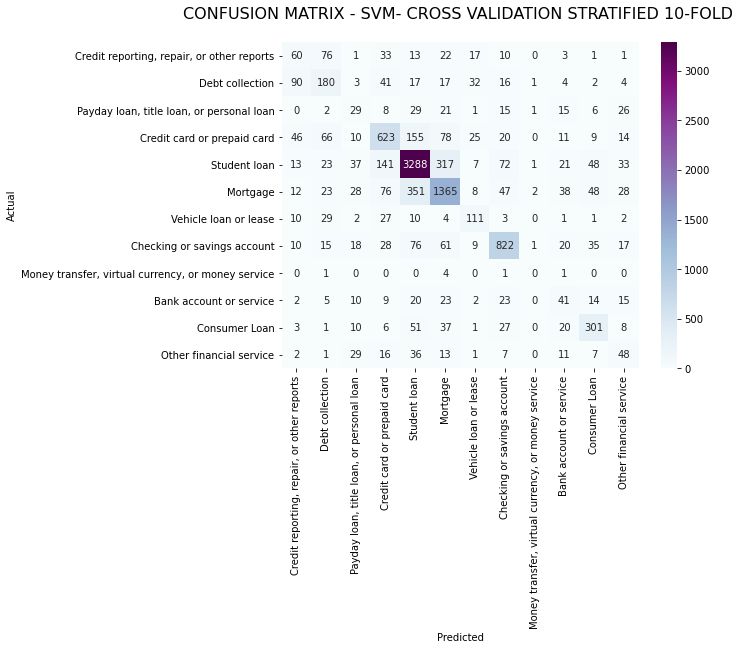

In [38]:


fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mx_SVM_s, annot=True, cmap="BuPu", fmt='d',
            xticklabels=dfNew.Product.unique(), 
            yticklabels=dfNew.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - SVM- CROSS VALIDATION STRATIFIED 10-FOLD \n", size=16);



In [39]:
import numbers
SVM_report['name']=SVM_report.index
SVM_report1=SVM_report.transpose()
SVM_report1.drop(SVM_report1.tail(1).index,inplace=True)
MeanSVM_Report = SVM_report1.groupby(by=SVM_report1.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
MeanSVM_Report.transpose()

,precision,recall,f1-score,support
Bank account or service,0.235496,0.253442,0.241984,23.7000
Checking or savings account,0.434001,0.442622,0.434733,40.7000
Consumer Loan,0.160879,0.190000,0.171683,15.3000
Credit card or prepaid card,0.618450,0.589461,0.602978,105.7000
"Credit reporting, repair, or other reports",0.812802,0.821791,0.817192,400.1000
Debt collection,0.696111,0.673706,0.684613,202.6000
"Money transfer, virtual currency, or money service",0.518555,0.555000,0.533760,20.0000
Mortgage,0.773406,0.739221,0.755390,111.2000
Other financial service,0.000000,0.000000,0.000000,0.8750
"Payday loan, title loan, or personal loan",0.229942,0.248162,0.232778,16.4000


CROSS VALIDATION KFOLD

In [34]:
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

X=dfNew.Consumer_complaint
y=dfNew['Product']


labels_l=['Bank account or service', 'Checking or savings account','Consumer Loan','Credit card or prepaid card',
          'Credit reporting, repair, or other reports','Debt collection',
          'Money transfer, virtual currency, or money service' ,'Mortgage','Other financial service',
          'Payday loan, title loan, or personal loan','Student loan','Vehicle loan or lease']


metricsSVM = []
conf_matrix_list_of_arrays_SVM =[]

SVM_report = pd.DataFrame(columns=['precision' , 'recall' ,'f1-score' , 'support'])

X_train, X_test, y_train, y_test =  model_selection.train_test_split(dfNew.Consumer_complaint, dfNew['Product'], random_state=1)
kf = KFold(n_splits=10, random_state=1)
kf.get_n_splits(X_train)
for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    vect = CountVectorizer(ngram_range=(1,2), max_features=1000 , stop_words="english")
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
        
    SVM_Final=LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=850,
          multi_class='crammer_singer', penalty='l2', random_state=None,
          tol=0.0001, verbose=0)
    
    
    SVM_Final.fit(X_train_dtm, y_train)
    y_pred_class_SVM = SVM_Final.predict(X_test_dtm)
    metricsSVM.append(accuracy_score(y_test, y_pred_class_SVM))
    SVM_report_tmp=pd.DataFrame(classification_report(y_test,y_pred_class_SVM, output_dict=True)).transpose()
    SVM_report=SVM_report.append(SVM_report_tmp)
    
    conf_matrix_list_of_arrays_SVM.append( confusion_matrix(y_test, y_pred_class_SVM, labels=labels_l))

metricsSVM = np.array(metricsSVM)
conf_mx=sum(conf_matrix_list_of_arrays_SVM)

print('Mean accuracy SVM: ', np.mean(metricsSVM, axis=0))
print('STD accuracy SVM: ', np.std(metricsSVM, axis=0))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/cond

Mean accuracy SVM:  0.6878
STD accuracy SVM:  0.01875526592720026


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


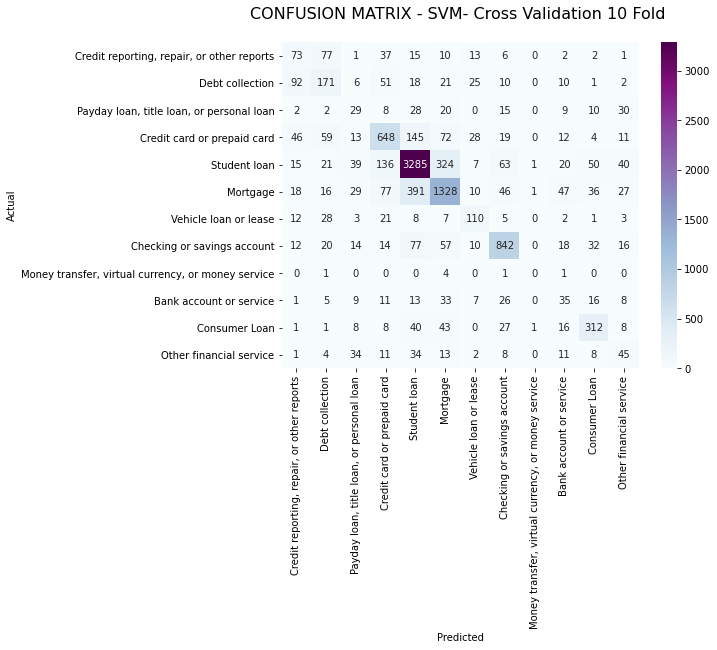

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mx, annot=True, cmap="BuPu", fmt='d',
            xticklabels=dfNew.Product.unique(), 
            yticklabels=dfNew.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - SVM- Cross Validation 10 Fold \n", size=16);

In [36]:
import numbers
SVM_report['name']=SVM_report.index
SVM_report1=SVM_report.transpose()
SVM_report1.drop(SVM_report1.tail(1).index,inplace=True)
MeanSVM_Report = SVM_report1.groupby(by=SVM_report1.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
MeanSVM_Report.transpose()

,precision,recall,f1-score,support
Bank account or service,0.273281,0.314179,0.284354,23.7000
Checking or savings account,0.431565,0.427327,0.424142,40.7000
Consumer Loan,0.167478,0.185290,0.168602,15.3000
Credit card or prepaid card,0.636468,0.612717,0.622683,105.7000
"Credit reporting, repair, or other reports",0.810286,0.821118,0.815430,400.1000
Debt collection,0.686526,0.654137,0.669598,202.6000
"Money transfer, virtual currency, or money service",0.517541,0.553058,0.528943,20.0000
Mortgage,0.788381,0.757075,0.771719,111.2000
Other financial service,0.000000,0.000000,0.000000,1.0000
"Payday loan, title loan, or personal loan",0.193911,0.208811,0.195703,16.4000


In the method below I apply fit() on whole data and then apply transform() on train set and test set separately

In [44]:
y = dfNew['Product']
X=dfNew.Consumer_complaint
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

tfidf = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X_train_counts = tfidf.fit_transform(X_train)
X_test_counts = tfidf.transform(X_test)

classifier=LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=850,
          multi_class='crammer_singer', penalty='l2', random_state=None,
          tol=0.0001, verbose=0)

classifier.fit(X_train_counts, y_train) 
y_pred = classifier.predict(X_test_counts)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))




[[ 10  25   0   7   5   2   2   2   0   0   0   0]
 [ 14  48   0  17   5   3   4   4   0   0   0   0]
 [  0   0   6   2   3   7   3   4   0   7   0  20]
 [  5  10   0 189  30  12   6   2   0   1   3   0]
 [  0   3   3  27 859  80   0  14   0   0   7   9]
 [  2   2   2   6  90 384   1  11   0   4  10   5]
 [  0   5   0   0   2   3  49   0   0   0   0   2]
 [  0   5   1   2  13   8   1 238   0   0   1   1]
 [  0   0   0   0   0   1   0   1   0   0   0   0]
 [  1   1   1   1   3   9   0   4   0  13   2   1]
 [  0   0   0   4  15   9   0   2   0   1  79   0]
 [  0   0   6   5   7   1   0   3   0   3   3  16]]
                                                    precision    recall  f1-score   support

                           Bank account or service       0.31      0.19      0.24        53
                       Checking or savings account       0.48      0.51      0.49        95
                                     Consumer Loan       0.32      0.12      0.17        52
                  

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


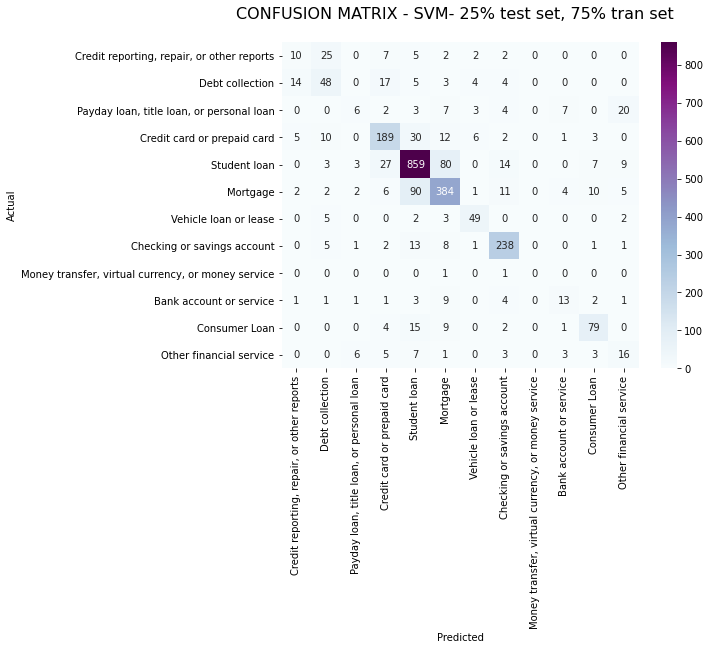

In [46]:
confusion_mc2=confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_mc2, annot=True, cmap="BuPu", fmt='d',
            xticklabels=dfNew.Product.unique(), 
            yticklabels=dfNew.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - SVM- 25% test set, 75% tran set  \n", size=16);